# Section 4: Case Study I - U-Net for Building Mapping

Now let's move in to a little advance model call U-Net. U-Net is popular in satellite image analysis (remote sensing) community. It’s very elegant and simple model that can be used to perform semantic segmentation task (labelling each pixel) well.

In this section, we will use U-Net to identify buildings from satellite images (2 class classification problem).

    1) U-Net for Building Mapping

<hr>
<hr>
<hr>

In [2]:
'''first, let's import libraries '''

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

## 1) U-Net for Building Mapping

Input data are RGB satellite images. And output are binary images. Pixel value is 0 for non-buildings and pixel value is 1 for buildings.

In [3]:
'''loading data'''

# data is already randomized and split in to training / test sets. So we can go ahead and use them as it is.
x_train = np.load('./data/SpaceNet/sat_train.npy').astype('float32')
y_train= np.load('./data/SpaceNet/bul_train.npy').astype('float32')
x_test = np.load('./data/SpaceNet/sat_test.npy').astype('float32')
y_test = np.load('./data/SpaceNet/bul_test.npy').astype('float32') 

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("y_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (70, 128, 128, 3)
y_train shape (70, 128, 128, 1)
y_test shape (30, 128, 128, 3)
y_test shape (30, 128, 128, 1)


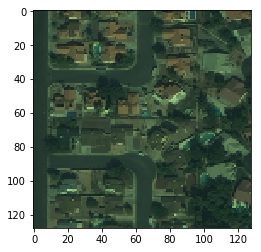

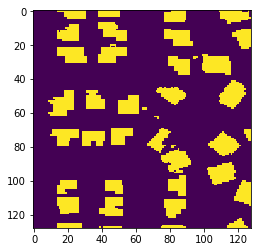

In [4]:
# Let's plot a sample input RGB image and output image with buildings

plt.imshow(x_test[10, :, :, :].astype('uint8'))
plt.show()
plt.imshow(y_test[10, :, :, 0].astype('uint8'))
plt.show()

#### First little bit about U-Net

Architecture of U-Net is in following figure,

<img src="./graphics/U-Net.PNG" width="60%"/>
<sub>Source of the figure: https://arxiv.org/pdf/1505.04597.pdf</sub>

It's very elegant and symmetric architecture. U-Net was first developed for biomedical image segmentation in a paper called "U-Net: Convolutional Networks for Biomedical Image Segmentation" (https://arxiv.org/pdf/1505.04597.pdf). And later, this architecture was widely adapted in satellite image analysis (remote sensing) community.

As in our last examples, in the left side of the network (Encoder), convolutional and max pooling operations down-sample the input image. And in the right side of the network (Decoder), transpose convolutional operations with and without strides up-sample output of the Encoder producing another image with same size as input image as the final output.

Another unique thing here is each corresponding down-sampling and up-sampling outputs with same sizes are connected (skip-connections) by __*Concatenation*__ operation. This skip-connections allow gradient (information) to pass through different  levels of the network efficiently, avoiding the bottleneck at the middle of the U-Net architecture. Now a days, these skip connections are widely used in various neural network architectures and they significantly improves performance of neural networks.

For skip-connections, we are using inbuilt __*Concatenate*__ function from Tensorflow (Keras) library. Due to this skip-connections, intermediate layers of the U-Net are connected. So U-Net can't be built as a __*Sequential*__ model as in out all past examples. Hence, we are using non-sequential model from Tensorflow (Keras) library for U-Net where input and output of each layer in the neural network is assigned to different variables.

Now, let's go ahead and define the U-Net model, fit, prediction and validate the output.

In [7]:
x_in = Input(shape=(128, 128, 3))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)
# use sigmoid activation here because output values are either 0 or 1

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 128, 128, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 128, 128, 32) 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 128, 32) 9248        dropout_8[0][0]                  
__________________________________________________________________________________________________
max_poolin

Another new concept here use of multiple __*Dropout*__ layers in the middle of the network. This helps reducing over-fitting during training process. Simply it randomly drops out (ignores) portion of layer outputs (in our case 25%). This allow making robust network architecture finally reducing over-fitting. Short description about __*Dropout*__ can be seen in this nice short video.(https://www.youtube.com/watch?v=NhZVe50QwPM)

In [8]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=10)

Train on 70 samples, validate on 30 samples
Epoch 1/100
70/70 [==============================] - 2s 27ms/step - loss: 0.2152 - val_loss: 0.2309
Epoch 2/100
70/70 [==============================] - 0s 4ms/step - loss: 0.2068 - val_loss: 0.2194
Epoch 3/100
70/70 [==============================] - 0s 4ms/step - loss: 0.1846 - val_loss: 0.1696
Epoch 4/100
70/70 [==============================] - 0s 4ms/step - loss: 0.1642 - val_loss: 0.1394
Epoch 5/100
70/70 [==============================] - 0s 4ms/step - loss: 0.1505 - val_loss: 0.1432
Epoch 6/100
70/70 [==============================] - 0s 4ms/step - loss: 0.1501 - val_loss: 0.1335
Epoch 7/100
70/70 [==============================] - 0s 4ms/step - loss: 0.1490 - val_loss: 0.1360
Epoch 8/100
70/70 [==============================] - 0s 4ms/step - loss: 0.1481 - val_loss: 0.1339
Epoch 9/100
70/70 [==============================] - 0s 4ms/step - loss: 0.1501 - val_loss: 0.1395
Epoch 10/100
70/70 [==============================] - 0s 4ms/ste

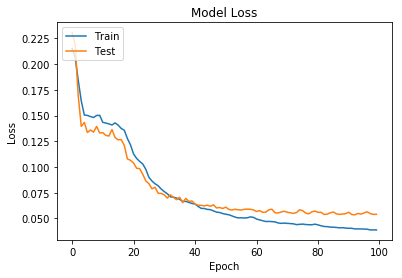

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

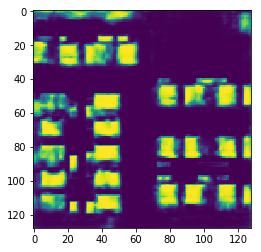

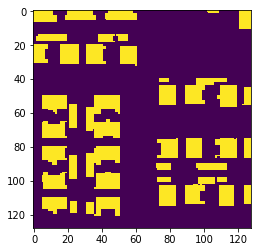

In [10]:
'''Prediction over the test dataset'''
pred_test = model.predict(x_test)

#let's comare random predicted and actial y values 
plt.imshow(pred_test[20, :, :, 0])
plt.show()
plt.imshow(y_test[20,:,:,0])
plt.show()

This is not an operational model with high accuracy. But with more layers and with more data, we can develop this architecture in to an operational model with high accuracy.